In [1]:
# import some visualization of libraries 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn import metrics
from scipy.spatial.distance import cdist
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [2]:
# Read the datasets
superstore_df = pd.read_csv("superstore_update.csv", encoding="ISO-8859-1")

In [3]:
superstore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      9994 non-null   int64  
 1   Order ID                        9994 non-null   object 
 2   Order Date                      9994 non-null   object 
 3   Ship Date                       9994 non-null   object 
 4   Ship Mode                       9994 non-null   object 
 5   Customer ID                     9994 non-null   object 
 6   Customer Name                   9994 non-null   object 
 7   Segment                         9994 non-null   object 
 8   Country                         9994 non-null   object 
 9   City                            9994 non-null   object 
 10  State                           9994 non-null   object 
 11  Postal Code                     9994 non-null   int64  
 12  Region                          99

In [4]:
superstore_df.tail()

,Unnamed: 0,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Estimated Sale Price p/unit,Estimated Profit p/unit,Estimated Profit Margin p/unit,Adjusted Discount,Action,Adjusted Sale Price p/unit,Projected Profit p/unit,Projected Profit Margin,Projected total profit,Projected Sales
9989,9989,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,8.416,3.0508,0.3625,0.291667,No Action Needed,8.416,3.0508,0.3625,9.1524,25.248
9990,9990,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,45.980,7.8166,0.1700,0.077778,No Action Needed,45.980,7.8166,0.1700,15.6332,91.960
9991,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,129.288,35.5542,0.2750,0.194444,Adjust Discount,129.288,35.5542,0.2750,71.1084,258.576
9992,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,7.400,3.3300,0.4500,0.388889,No Action Needed,7.400,3.3300,0.4500,13.3200,29.600
9993,9993,CA-2017-119914,5/4/2017,5/9/2017,Second Class,CC-12220,Chris Cortes,Consumer,United States,Westminster,...,121.580,36.4740,0.3000,0.222222,No Action Needed,121.580,36.4740,0.3000,72.9480,243.160


In [5]:
# formatting date columns

superstore_df["Order Date"] = pd.to_datetime(superstore_df["Order Date"])
superstore_df["Ship Date"] = pd.to_datetime(superstore_df["Ship Date"])

# Clustering

#NOTE - i will group for the last year to have a more coherent result

In [ ]:
# superstore_2017 = superstore_df[superstore_df["Order Date"].dt.year == 2017]

In [101]:
# Group customers by purchase amount
customers_by_purchase = superstore_df.groupby("Customer ID")["Sales"].mean().reset_index(name="Purchase Amount")

In [102]:
# Group customers by frequency of purchase
customers_by_frequency = superstore_df.groupby("Customer ID")["Order ID"].count().reset_index(name="Frequency")
customers_by_frequency

,Customer ID,Frequency
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6
...,...,...
788,XP-21865,28
789,YC-21895,8
790,YS-21880,12
791,ZC-21910,31


In [103]:
# Group customers by recency (how many days have passed from their last purchase)

## last order in the dataset
last_order_date = superstore_df["Order Date"].max()

## Calculating time (days) difference
superstore_df["days_elapsed"] = (last_order_date- superstore_df["Order Date"]).dt.days

customers_by_recency = superstore_df.groupby("Customer ID")["days_elapsed"].min().reset_index(name="Recency")
customers_by_recency

,Customer ID,Recency
0,AA-10315,184
1,AA-10375,19
2,AA-10480,259
3,AA-10645,55
4,AB-10015,415
...,...,...
788,XP-21865,43
789,YC-21895,4
790,YS-21880,9
791,ZC-21910,54


In [104]:
# Merging the 3 data sets
merged_purchase_frequency = pd.merge (customers_by_purchase, customers_by_frequency)
merged_customers_info = pd.merge (merged_purchase_frequency, customers_by_recency)

In [105]:
merged_customers_info

,Customer ID,Purchase Amount,Frequency,Recency
0,AA-10315,505.778182,11,184
1,AA-10375,70.426000,15,19
2,AA-10480,149.209333,12,259
3,AA-10645,282.607500,18,55
4,AB-10015,147.692667,6,415
...,...,...,...,...
788,XP-21865,84.809214,28,43
789,YC-21895,681.793750,8,4
790,YS-21880,560.037000,12,9
791,ZC-21910,258.893774,31,54


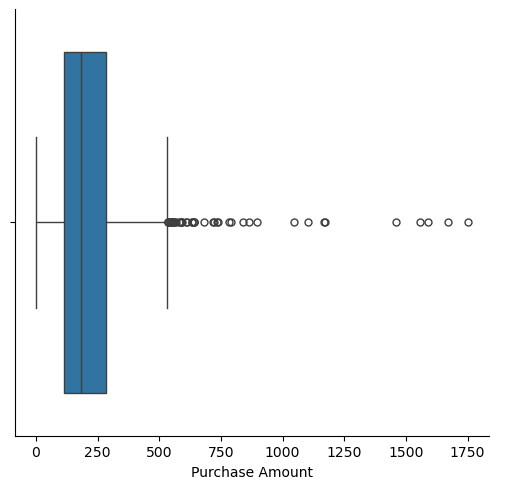

In [106]:
# Checking distribution of sales with a boxplot
sns.catplot(data = merged_customers_info, kind="box", x = "Purchase Amount")

<Axes: xlabel='Purchase Amount', ylabel='Count'>

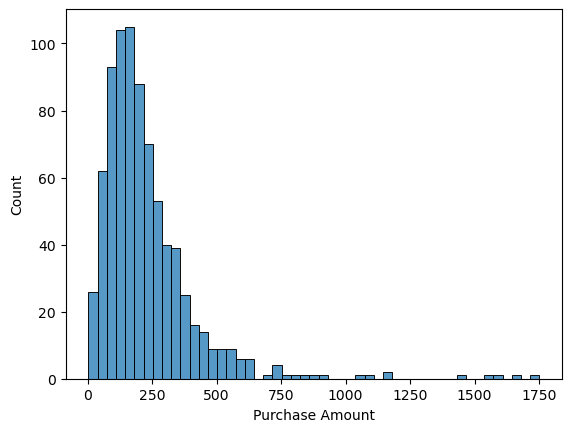

In [107]:
sns.histplot(data=merged_customers_info, x = "Purchase Amount")

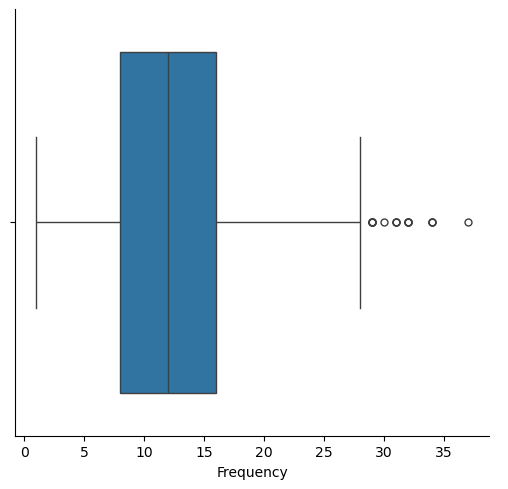

In [108]:
# Checking distribution of frequency with a boxplot
sns.catplot(data = merged_customers_info, kind="box", x = "Frequency")

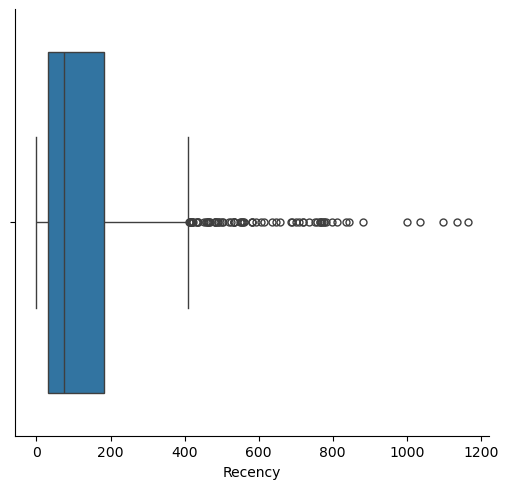

In [109]:
# Checking distribution of recency  with a boxplot
sns.catplot(data = merged_customers_info, kind="box", x = "Recency")

## Dealing with Outliers with IQR

In [110]:
# Filter purchases
## Compute the first and third quantiles and IQR for purchases

q1 = np.quantile(merged_customers_info["Purchase Amount"], 0.25)
q3 = np.quantile(merged_customers_info["Purchase Amount"], 0.75)
iqr = q3 - q1

## Calculate the lower and upper cutoffs for outliers
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

purchase_filtered = merged_customers_info[(merged_customers_info["Purchase Amount"]> lower) & (merged_customers_info["Purchase Amount"] < upper)]


<Axes: xlabel='Purchase Amount'>

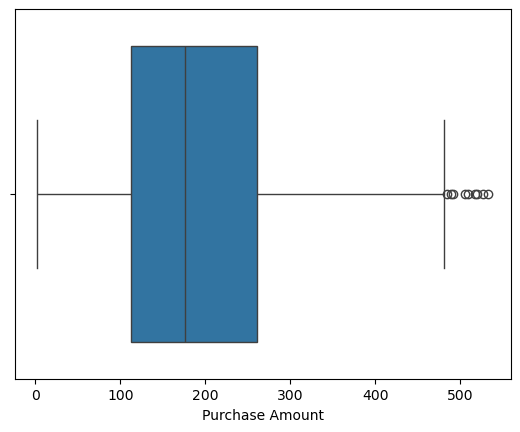

In [111]:
sns.boxplot(data=purchase_filtered, x="Purchase Amount")

In [112]:
purchase_filtered.size

3000

In [113]:
# Filter frequency
## Compute the first and third quantiles and IQR for frequency

q1 = np.quantile(purchase_filtered["Frequency"], 0.25)
q3 = np.quantile(purchase_filtered["Frequency"], 0.75)
iqr = q3 - q1

## Calculate the lower and upper cutoffs for outliers
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

frequency_filtered = purchase_filtered[(purchase_filtered["Frequency"]> lower) & (purchase_filtered["Frequency"] < upper)]


In [114]:
frequency_filtered.size

2912

<Axes: xlabel='Frequency'>

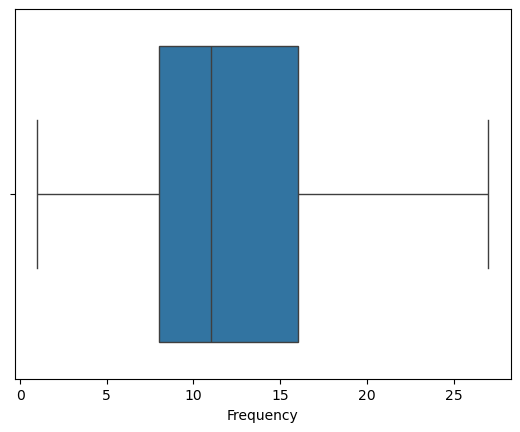

In [115]:
sns.boxplot(data=frequency_filtered, x="Frequency")

In [116]:
# Filter Recency
## Compute the first and third quantiles and IQR for recency

q1 = np.quantile(frequency_filtered["Recency"], 0.25)
q3 = np.quantile(frequency_filtered["Recency"], 0.75)
iqr = q3 - q1

## Calculate the lower and upper cutoffs for outliers
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

customers_features_filtered = frequency_filtered[(frequency_filtered["Recency"]> lower) & (frequency_filtered["Recency"] < upper)]


<Axes: xlabel='Recency'>

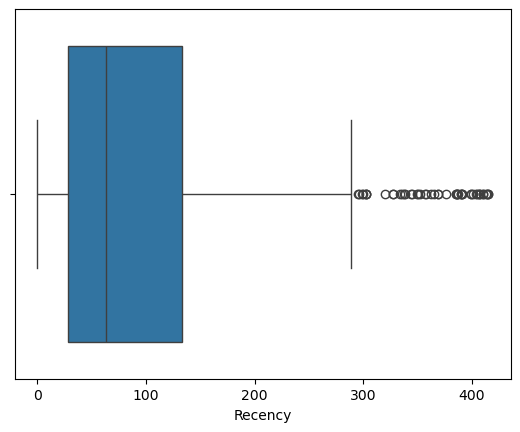

In [117]:
sns.boxplot(data=customers_features_filtered, x="Recency")

In [118]:
print(f'Number of Customers before filtering: {superstore_df["Customer ID"].nunique()}')
print(f'Number of Customers after filtering: {len(customers_features_filtered)}')

Number of Customers before filtering: 793
Number of Customers after filtering: 661


## Scaling

1️⃣ Use StandardScaler (Z-score normalization) if:

Your features (Purchase Amount, Frequency, Recency) follow a normal distribution (or close to it).
You want to give equal weight to all features in clustering.
You don’t have severe outliers left after IQR filtering.
2️⃣ Use RobustScaler if:

Your features still have some outliers (even after IQR filtering).
You have a skewed distribution (e.g., Purchase Amount is right-skewed due to high-value customers).
You want to reduce the influence of extreme values without removing them.

I'm using robustscaler


In [119]:
# Apply Log Transformation to Purchase Amount
customers_features_filtered.loc[:,"Log_Purchase_Amount"] = np.log1p(customers_features_filtered["Purchase Amount"])  # log(x + 1) to handle zero values

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2135/4149599715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_features_filtered.loc[:,"Log_Purchase_Amount"] = np.log1p(customers_features_filtered["Purchase Amount"])  # log(x + 1) to handle zero values


In [134]:
from sklearn.preprocessing import RobustScaler
from scipy.stats import chi2

# RobustScaler
## Select relevant features for clustering
features = ["Log_Purchase_Amount", "Frequency", "Recency"]
data = customers_features_filtered[features].copy()

## Apply Robust Scaling (scales using median & IQR, resistant to outliers)
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

## Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df

,Log_Purchase_Amount,Frequency,Recency
0,1.265390,-0.142857,1.152381
1,-1.106967,0.428571,-0.419048
2,-0.206935,0.000000,1.866667
3,0.562571,0.857143,-0.076190
4,-0.219222,-0.857143,3.352381
...,...,...,...
656,0.138358,-1.000000,-0.314286
657,0.365657,0.285714,0.114286
658,-0.354281,-0.571429,1.504762
659,0.788468,0.857143,-0.333333


In [135]:
# Add Customer ID for reference 

if "Customer ID" in customers_features_filtered.columns:
    scaled_df["Customer ID"] = customers_features_filtered["Customer ID"]


### filtiering with Mahalanobis Distance

In [136]:
# from scipy.stats import chi2


# # Compute the mean and covariance matrix for Mahalanobis Distance
# mean_vector = np.mean(scaled_data, axis=0)
# cov_matrix = np.cov(scaled_data, rowvar=False)
# inv_cov_matrix = np.linalg.inv(cov_matrix)

# # Compute Mahalanobis Distance
# diff = scaled_data - mean_vector
# mahalanobis_dist = np.sqrt(np.diag(diff @ inv_cov_matrix @ diff.T))

# # Set threshold for outlier detection (p < 0.001, critical value for Chi-Square distribution)
# threshold = chi2.ppf(0.95, df=len(features))

# # Flag outliers
# outliers = mahalanobis_dist > threshold

# # Add Mahalanobis Distance and Outlier Flag to the dataset
# merged_customers_info.loc[:,"Mahalanobis Distance"] = mahalanobis_dist
# merged_customers_info.loc[:,"Outlier"] = outliers

# # Filter out extreme outliers based on Mahalanobis Distance
# filtered_mahalanobis_df = merged_customers_info[~merged_customers_info["Outlier"]].drop(columns=["Outlier", "Mahalanobis Distance"])

# # Display the dataset after Mahalanobis outlier removal
# filtered_mahalanobis_df

## Determine Optimal number of Clusters using Elbow method & Silhoutte Score

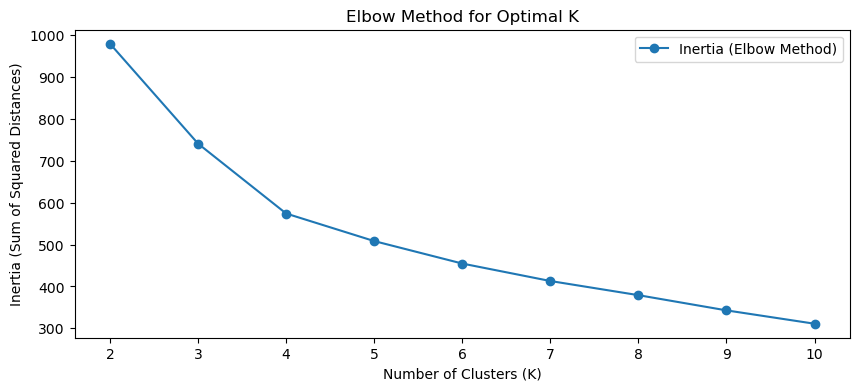

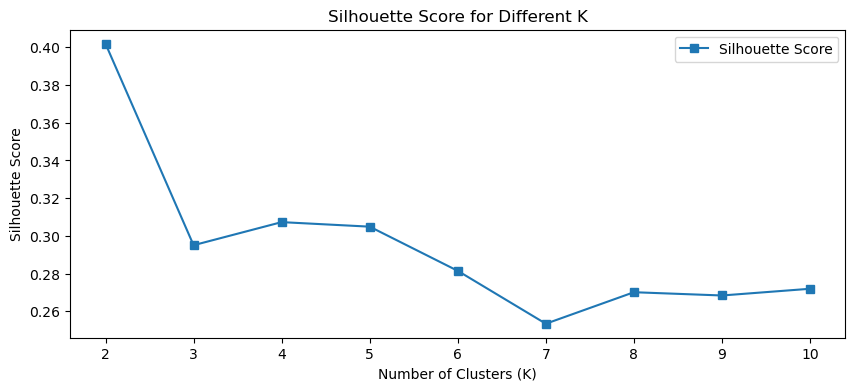

In [137]:
# Prepare data for clustering (excluding Customer ID)
scaled_data = scaled_df[features]

# Determine the optimal number of clusters using Elbow Method & Silhouette Score
inertia = []  # Stores inertia (SSE) for Elbow Method
silhouette_scores = []  # Stores silhouette scores

K_range = range(2, 11)  # Testing clusters from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to centroids (Elbow Method)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))  # Silhouette Score

# Plot the Elbow Method
plt.figure(figsize=(10, 4))
plt.plot(K_range, inertia, marker='o', linestyle='-', label="Inertia (Elbow Method)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

# Plot the Silhouette Score
plt.figure(figsize=(10, 4))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', label="Silhouette Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K")
plt.legend()
plt.show()



#NOTE - 3 seems to be the best number of Clusters

## Applying K means

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_2135/2983134873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_features_filtered["Cluster"] = kmeans.fit_predict(scaled_data)


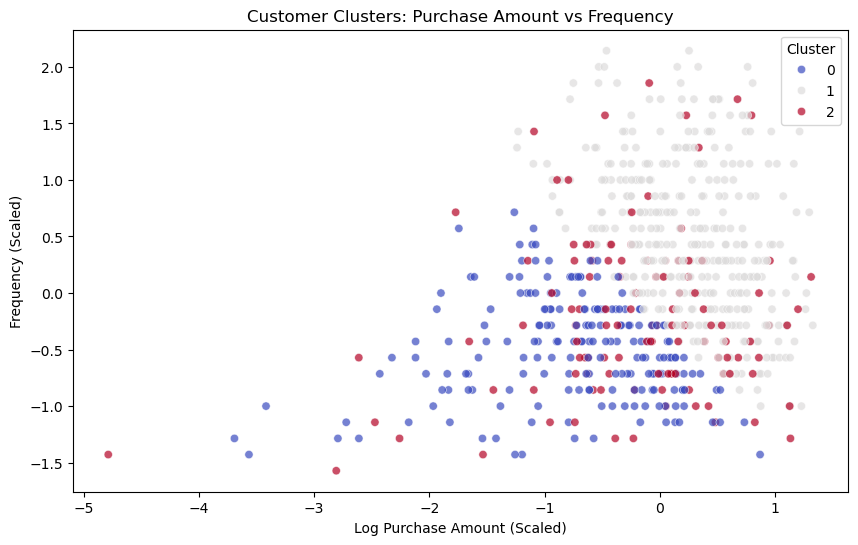

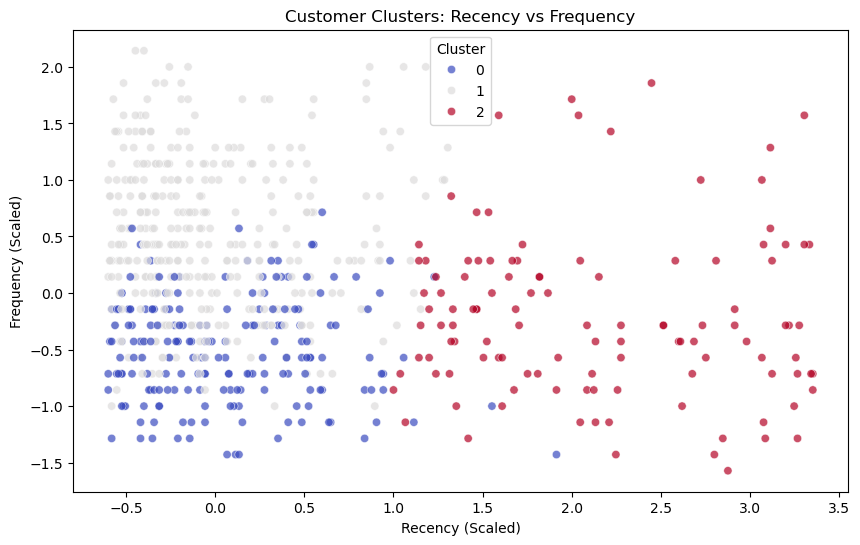

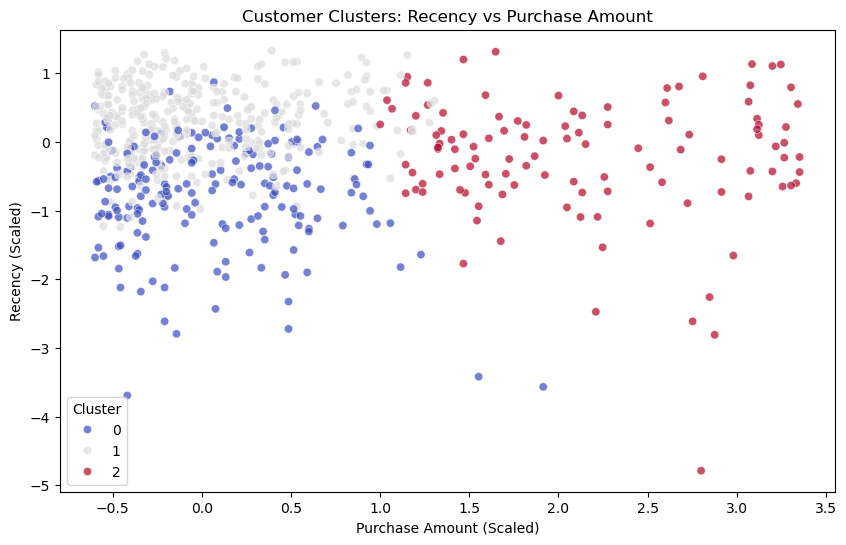

In [138]:
# Apply K-Means Clustering using the optimal K from the Elbow & Silhouette methods
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]  # Choose best K based on Silhouette Score

# Run K-Means with the optimal number of clusters
final_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
scaled_df["Cluster"] = final_kmeans.fit_predict(scaled_data)

customers_features_filtered["Cluster"] = kmeans.fit_predict(scaled_data)


# Visualize Clusters: Purchase Amount vs Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_df["Log_Purchase_Amount"],
    y=scaled_df["Frequency"],
    hue=scaled_df["Cluster"],
    palette="coolwarm",
    alpha=0.7
)
plt.xlabel("Log Purchase Amount (Scaled)")
plt.ylabel("Frequency (Scaled)")
plt.title("Customer Clusters: Purchase Amount vs Frequency")
plt.legend(title="Cluster")
plt.show()

# Visualize Clusters: Recency vs Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_df["Recency"],
    y=scaled_df["Frequency"],
    hue=scaled_df["Cluster"],
    palette="coolwarm",
    alpha=0.7
)
plt.xlabel("Recency (Scaled)")
plt.ylabel("Frequency (Scaled)")
plt.title("Customer Clusters: Recency vs Frequency")
plt.legend(title="Cluster")
plt.show()

# Visualize Clusters: Recency vs Purchase
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_df["Recency"],
    y=scaled_df["Log_Purchase_Amount"],
    hue=scaled_df["Cluster"],
    palette="coolwarm",
    alpha=0.7
)
plt.xlabel("Purchase Amount (Scaled)")
plt.ylabel("Recency (Scaled)")
plt.title("Customer Clusters: Recency vs Purchase Amount")
plt.legend(title="Cluster")
plt.show()




## 3d plotting

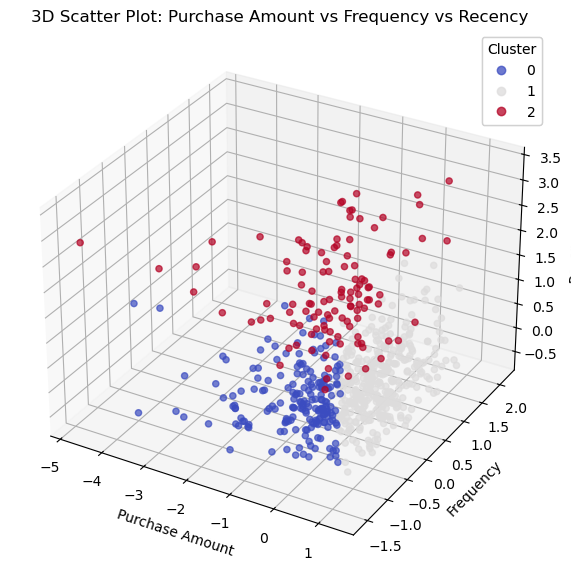

In [139]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract the three main features for the 3D scatter plot
x = scaled_df["Log_Purchase_Amount"]
y = scaled_df["Frequency"]
z = scaled_df["Recency"]

# Scatter plot with color based on the cluster (if clustering has been done)
if "Cluster" in scaled_df.columns:
    scatter = ax.scatter(x, y, z, c=scaled_df["Cluster"], cmap="coolwarm", alpha=0.7)
    legend = ax.legend(*scatter.legend_elements(), title="Cluster")
    ax.add_artist(legend)
else:
    ax.scatter(x, y, z, alpha=0.7)

# Labels and title
ax.set_xlabel("Purchase Amount")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("3D Scatter Plot: Purchase Amount vs Frequency vs Recency")

plt.show()

In [140]:
#interpretation
## adding the cluster column to the unscaled df
customers_features_filtered.loc[:,"Cluster"] = final_kmeans.fit_predict(scaled_data)

# Analyze and interpret clusters
cluster_summary = customers_features_filtered.groupby("Cluster").agg(
    Avg_Purchase_Amount=("Purchase Amount", "mean"),
    Avg_Frequency=("Frequency", "mean"),
    Avg_Recency=("Recency", "mean"),
    Count_Customers=("Cluster", "count")
).reset_index()

In [141]:
cluster_summary

,Cluster,Avg_Purchase_Amount,Avg_Frequency,Avg_Recency,Count_Customers
0,0,113.733145,8.455497,69.345550,191
1,1,242.624224,15.477528,58.632022,356
2,2,181.262874,10.464912,286.780702,114
